## Titanic with Pipeline for MASTER

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/pillar.jpg' width=600>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer,OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [59]:
path ='https://frenzy86.s3.eu-west-2.amazonaws.com/fav/tecno/titanic.csv'
df = pd.read_csv(path, sep='\t')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,1,1,"Pears, Mrs. Thomas (Edith Wearne)",female,22.0,1,0,113776,66.6000,C2,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S


In [60]:
#STEP 0 FILTERING
#remove features not useful
features_to_remove = ['Name', 'PassengerId', 'Ticket', 'Cabin']
df_clean = df.drop(features_to_remove, axis=1)

In [61]:
# STEP 1 - TRAIN TEST SPLITTING
#Feature matrix and target vector
X = df_clean.drop(['Survived'], axis=1) # matrice Features
y = df_clean['Survived']                #Target

In [62]:
y

0      0
1      1
2      1
3      1
4      0
      ..
151    1
152    0
153    0
154    0
155    0
Name: Survived, Length: 156, dtype: int64

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/pipes.png' width=700>

## Simple Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Il SimpleImputer è utilizzato per gestire i valori mancanti (NaN) all'interno dei dati. Nella tua pipeline, viene utilizzato per imputare i valori mancanti nelle feature numeriche, sostituendoli con la mediana dei valori presenti in quella colonna.

Ad esempio, supponiamo di avere una feature numerica come l'età di una persona e alcuni valori sono mancanti. Utilizzando SimpleImputer(strategy='median'), verranno sostituiti i valori mancanti con la mediana dell'età di tutte le altre persone.

Questo aiuta a mantenere la completezza dei dati durante l'analisi, poiché molti algoritmi di machine learning non possono gestire direttamente i valori mancanti.

- Se impostato su "mean", sostituisce i valori mancanti utilizzando la media lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "median", sostituisce i valori mancanti utilizzando la mediana lungo ciascuna colonna. Può essere utilizzato solo con dati numerici.

- Se impostato su "most_frequent", sostituisce i valori mancanti utilizzando il valore più frequente lungo ciascuna colonna. Può essere utilizzato con dati di tipo stringa o numerici. Se ci sono più valori più frequenti, viene restituito solo il più piccolo.

- Se impostato su "constant", sostituisce i valori mancanti con il valore specificato in fill_value. Può essere utilizzato con dati di tipo stringa o numerici.



In [63]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [64]:
## dividiamo automaticamente le features numeriche da quelle categoriche

numerical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind in ['i','f'] ]
categorical_features = [x for x, dtype in zip(X.columns, X.dtypes) if dtype.kind not in ['i','f']]

print('Numerical : ' + str(numerical_features))
print('Categorical : ' + str(categorical_features))

Numerical : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical : ['Sex', 'Embarked']


In [65]:
## Parte di processingdata: Cleaning, fill Nan + OHE
Preprocessor = make_column_transformer(
                                        (make_pipeline(
                                        SimpleImputer(strategy = 'median'),
                                        KBinsDiscretizer(n_bins=3)), numerical_features),

                                        (make_pipeline(
                                        #FunctionTransformer(lambda x: np.where(x == 'n.d.', np.nan, x)),
                                        SimpleImputer(strategy = 'constant', fill_value = 'missing'),
                                        OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features)
                                        )

In [66]:
scaler = StandardScaler()

classifier = RandomForestClassifier(bootstrap=True,
                                    max_depth=80,
                                    max_features=2,
                                    min_samples_leaf=3,
                                    min_samples_split=8,
                                    n_estimators=100
                                    )
#classifier = LogistiRegression()

In [67]:
model_pipe = Pipeline([
                       ('Preprocessing features', Preprocessor),
                       ('Scaling and standadize data', scaler),
                       ('Classifier', classifier)
                      ])
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [68]:
cross_val_scores = cross_val_score(model_pipe, X, y, cv=5)
print(cross_val_scores)

# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scores)
std_score = np.std(cross_val_scores)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[0.84375    0.80645161 0.80645161 0.77419355 0.77419355]
Mean cross-validation score:0.80
Standard deviation of cross-validation scores:0.03


##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>


In [69]:
model_pipe.fit(X, y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [70]:
y_pred_tot = model_pipe.predict(X)

In [71]:
from sklearn.metrics import classification_report

classification_report(y,y_pred_tot )

classification_report_result = classification_report(y, y_pred_tot)
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       102
           1       0.88      0.67      0.76        54

    accuracy                           0.85       156
   macro avg       0.86      0.81      0.83       156
weighted avg       0.86      0.85      0.85       156



### Prediction of Test

In [72]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/titanic-test.csv

Pclass	Sex	Age	SibSp	Parch	Fare	Embarked
(1,male,35,1,0,53.1,S)

In [73]:
test = pd.read_csv('https://frenzy86.s3.eu-west-2.amazonaws.com/python/titanic-test.csv')
test_clean = test.drop(features_to_remove, axis = 1)
test_clean

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [74]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [75]:
test_pred = model_pipe.predict(test_clean).astype(int)
test_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [76]:
#kaggle competition export
sub = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                        'Survived' : test_pred})

sub.to_csv("solu_RF_pipe.csv", index = False)

## Prediction of single observation

In [77]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [78]:
Age= 34
Embarked = 'Q'
Fare =7.8
Parch = 0
Pclass = 3
Sex = 'female'
SibSp = 0

data = {
        "Pclass": [Pclass],
        "Sex": [Sex],
        "Age": [Age],
        "SibSp": [SibSp],
        "Parch": [Parch],
        "Fare": [Fare],
        "Embarked": [Embarked]
        }

input_df = pd.DataFrame(data)
res = model_pipe.predict(input_df).astype(int)[0]
print(res)

classes = {0:'died',
           1:'survived',
           }

y_pred = classes[res]
y_pred

1


'survived'

In [79]:
import joblib

joblib.dump(model_pipe,'titanic_pipe.pkl')

['titanic_pipe.pkl']

## Load model .pkl

In [80]:
import joblib

model_pipe = joblib.load('titanic_pipe.pkl')
print('Model loaded successfully')

Model loaded successfully


In [81]:
model_pipe

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [82]:
Age= 34
Embarked = 'Q'
Fare =7.8
Parch = 0
Pclass = 3
Sex = 'female'
SibSp = 0

data = {
        "Pclass": [Pclass],
        "Sex": [Sex],
        "Age": [Age],
        "SibSp": [SibSp],
        "Parch": [Parch],
        "Fare": [Fare],
        "Embarked": [Embarked]
        }
classes = {0:'died',
           1:'survived',
           }

res = model_pipe.predict(input_df).astype(int)[0]
print(res)

y_pred = classes[res]
y_pred

1


'survived'

## Test Pipeline con PCA prima del Classifier

In [83]:
from sklearn.decomposition import PCA

pca= PCA()
model_pipe_pca = Pipeline([
                        ('Preprocessing features', Preprocessor),
                        ('Scaling and standadize data', scaler),
                        # sempre prima del classifier e dopo lo scaling
                        ('PCA',pca),
                        ('Classifier', classifier)
                        ])

model_pipe_pca

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('PCA', PCA()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

In [84]:
cross_val_scorespca = cross_val_score(model_pipe_pca, X, y, cv=5)
print(cross_val_scorespca)
# Calcola la media e la deviazione standard dei punteggi
mean_score = np.mean(cross_val_scorespca)
std_score = np.std(cross_val_scorespca)

print(f"Mean cross-validation score:{mean_score:.2f}")
print(f"Standard deviation of cross-validation scores:{std_score:.2f}")

[0.875      0.80645161 0.80645161 0.77419355 0.74193548]
Mean cross-validation score:0.80
Standard deviation of cross-validation scores:0.04


##Fit the model with entire dataset

<img src='https://frenzy86.s3.eu-west-2.amazonaws.com/python/cross.png' width=600>



In [85]:
model_pipe_pca.fit(X,y)

Pipeline(steps=[('Preprocessing features',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(n_bins=3))]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('Scaling and standadize data', StandardScaler()),
                ('PCA', PCA()),
                ('Classifier',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=8))])

## La PCA non ha cambiato di moltissimo sul test set

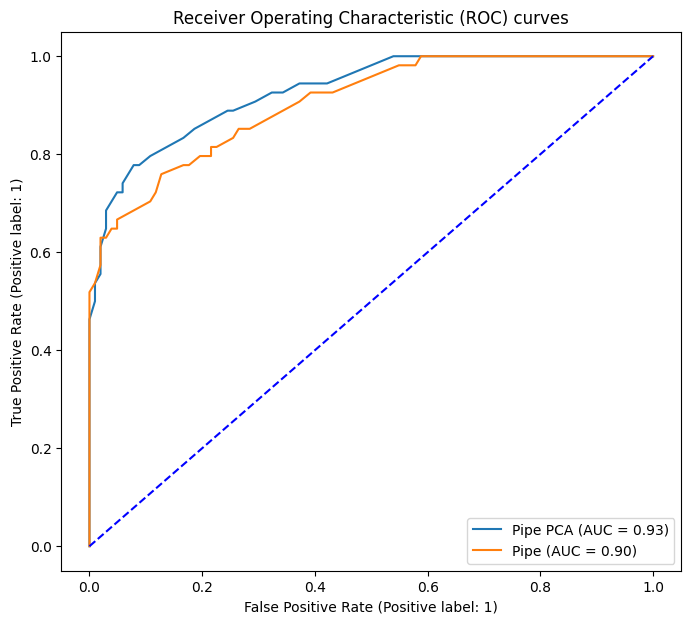

In [86]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

# Calculate AUC for each model
auc_pipe_pca = roc_auc_score(y, model_pipe_pca.predict_proba(X)[:, 1])
auc_pipe = roc_auc_score(y, model_pipe.predict_proba(X)[:, 1])

plt.figure(figsize=(8,7))
ax = plt.gca()

# Plot ROC curves and add AUC to the legend
RocCurveDisplay.from_estimator(model_pipe_pca, X, y, label=f'Pipe PCA (AUC = {auc_pipe_pca:.2f})', ax=ax)
RocCurveDisplay.from_estimator(model_pipe, X, y, label=f'Pipe (AUC = {auc_pipe:.2f})', ax=ax)
plt.plot([0,1],[0,1],'--b')

plt.title("Receiver Operating Characteristic (ROC) curves")
plt.legend(loc=4);